<a href="https://colab.research.google.com/github/sreya-rc/TF2.0/blob/main/TF2_0_LSTM_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
try:
  %tensorflow_version 2.x # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [2]:
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:
$x(t) = sin(ωt^2)$

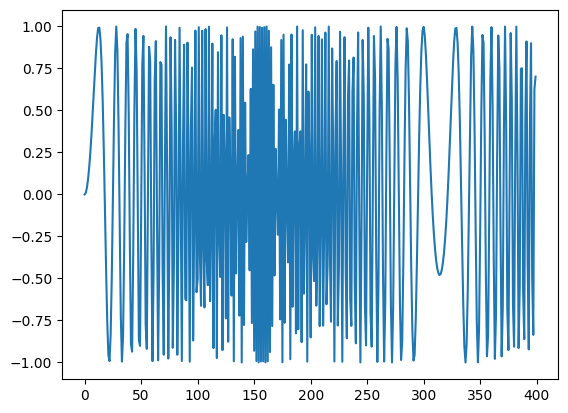

In [4]:
# Plot the time series
plt.plot(series)
plt.show()

In [5]:
# Build dataset
# Use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)   # Now the data should be (N x T x D)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390,)


In [6]:
# Try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(0.01)
)

# Train RNN
# The model trains only on the first half of the dataset and validates on the second half
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
7/7 [==============================] - 8s 61ms/step - loss: 1.9901 - val_loss: 1.4166
Epoch 2/80
7/7 [==============================] - 0s 20ms/step - loss: 1.6841 - val_loss: 1.3538
Epoch 3/80
7/7 [==============================] - 0s 34ms/step - loss: 1.4926 - val_loss: 1.2818
Epoch 4/80
7/7 [==============================] - 0s 30ms/step - loss: 1.3263 - val_loss: 1.2055
Epoch 5/80
7/7 [==============================] - 0s 20ms/step - loss: 1.2036 - val_loss: 1.1237
Epoch 6/80
7/7 [==============================] - 0s 30ms/step - loss: 1.0903 - val_loss: 1.0493
Epoch 7/80
7/7 [==============================] - 0s 26ms/step - loss: 0.9850 - val_loss: 0.9824
Epoch 8/80
7/7 [==============================] - 0s 24ms/step - loss: 0.9049 - val_loss: 0.9176
Epoch 9/80
7/7 [==============================] - 0s 15ms/step - loss: 0.8374 - val_loss: 0.8522
Epoch 10/80
7/7 [==============================] - 0s 12ms/step - loss: 0.7758 - val_loss: 0.7999
Epoch 11/80
7/7 [============

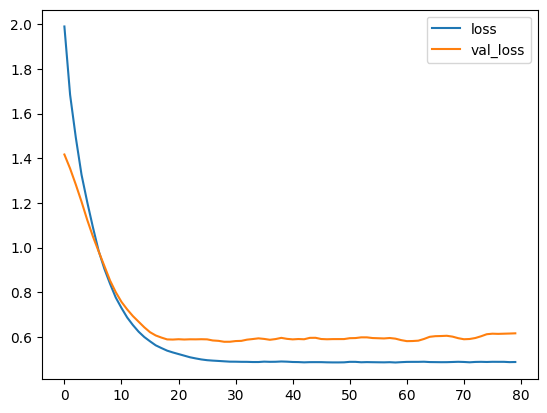

In [7]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

13/13 [==============================] - 0s 2ms/step
(390, 1)


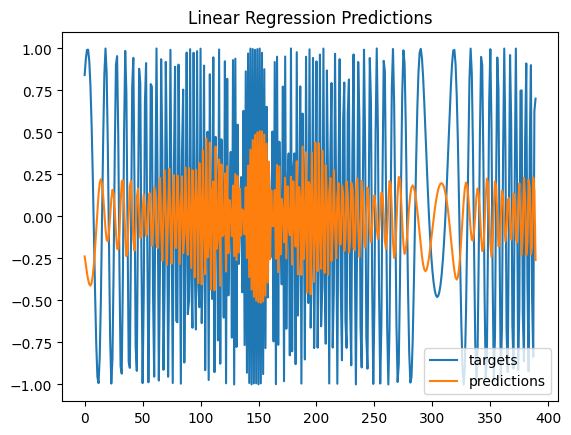

In [8]:
# One-step forecast using true targets
# Note: this is a shortcut since the input data has already been built
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 19ms/step


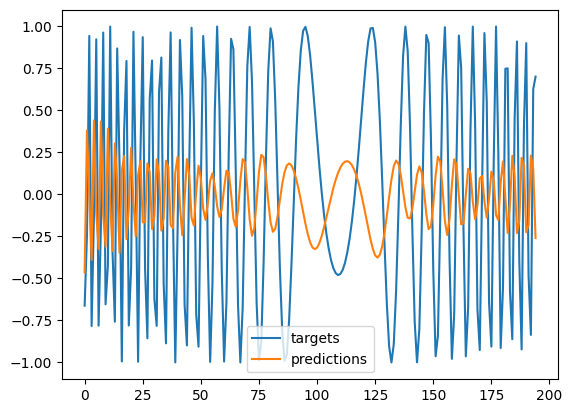

In [9]:
# One-step forecast as well - only going through the validation set
validation_target = Y[-N//2:]   # Validation target (test set) ==  second half of Y
validation_predictions = []

# Index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1, 1))[0,0]    # (1 x 1) array --> scalar transformation
  i += 1

  # Update predcitions list
  validation_predictions.append(p)

plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()

1/1 [==============================] - 0s 23ms/step


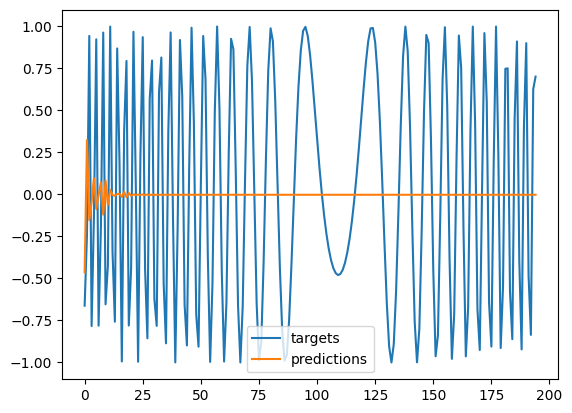

In [10]:
# Multi-step forecast
validation_target = Y[-N//2:]   # Validation target ==  second half of Y
validation_predictions = []

# Last train input
last_x = X[-N//2]    # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1, 1))[0,0]    # (1 x 1) array --> scalar transformation

  # Update the predictions list
  validation_predictions.append(p)

  # Make the new input
  # Shift all values of input array to the left - rightmost value moves to the very left, but gets replaced by p
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()

In [11]:
# Now try RNN/LSTM model for nonlinear data
X = X.reshape(-1, T, 1)     # make it (N x T x D)

# Make an RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(0.05)
)

# Train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size=32,
    epochs=200,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/200
7/7 [==============================] - 4s 79ms/step - loss: 0.5123 - val_loss: 0.6657
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 0.5364 - val_loss: 0.6699
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 0.4994 - val_loss: 0.6100
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 0.5217 - val_loss: 0.5827
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 0.4973 - val_loss: 0.5759
Epoch 6/200
7/7 [==============================] - 0s 11ms/step - loss: 0.4889 - val_loss: 0.5577
Epoch 7/200
7/7 [==============================] - 0s 13ms/step - loss: 0.4653 - val_loss: 0.5382
Epoch 8/200
7/7 [==============================] - 0s 10ms/step - loss: 0.4345 - val_loss: 0.5127
Epoch 9/200
7/7 [==============================] - 0s 11ms/step - loss: 0.3965 - val_loss: 0.4864
Epoch 10/200
7/7 [==============================] - 0s 10ms/step - loss: 0.3434 - val_loss: 0.4749
Epoch 11/200
7/7 [=

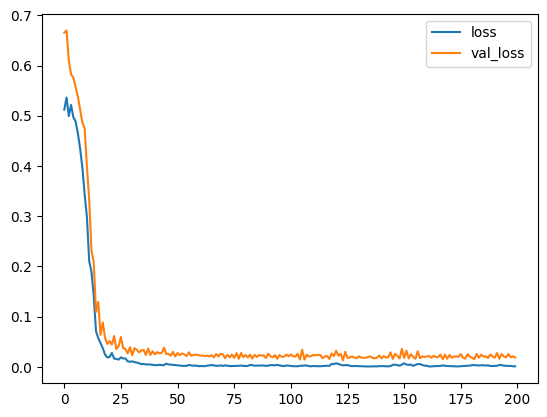

In [12]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

13/13 [==============================] - 0s 3ms/step
(390, 1)


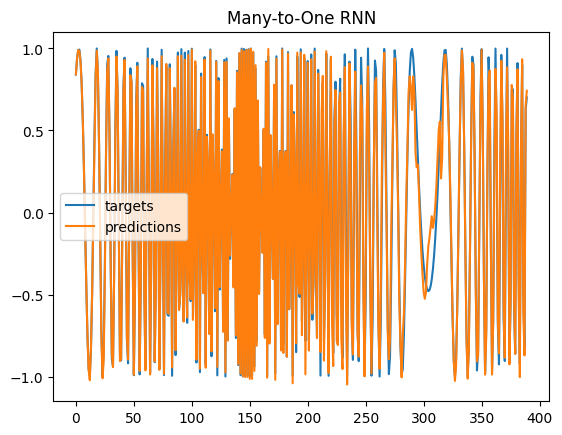

In [13]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Many-to-One RNN')
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step


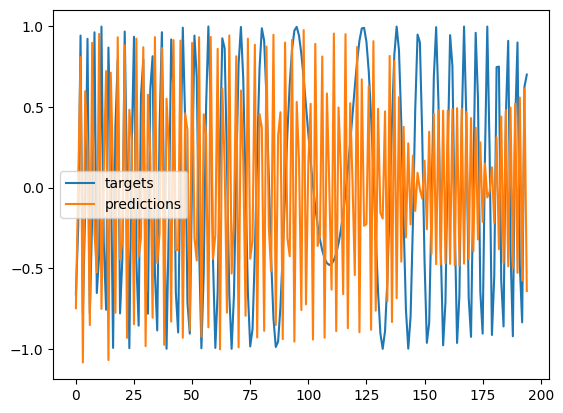

In [14]:
# Multi-step forecast
validation_target = Y[-N//2:]   # Validation target ==  second half of Y
validation_predictions = []

# Last train input
last_x = X[-N//2]    # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1, 1))[0,0]    # (1 x 1) array --> scalar transformation

  # Update the predictions list
  validation_predictions.append(p)

  # Make the new input
  # Shift all values of input array to the left - rightmost value moves to the very left, but gets replaced by p
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()